### Multi-input NN with PyTorch Lightning

In this Notebook we see how to create a **multi-input NN**: a NN that has as input an image + tabular data

I have started from the example by M. Rosenfelder here: https://rosenfelder.ai/multi-input-neural-network-pytorch/

I have made some modifications:
* removed the need to use the pickle file. The csv file extracted (tab_data.csv) is in my GotHUb repo, in the same dir as this NoteBook
* I have changed the LR
* The dataset is only split in train/validation to have more data for training
* I have added a LRSCheduler (ReduceLROnPlateau)
* I have done some other changes to make the code a little clearer (in my view)

Images can be found here: https://1drv.ms/u/s!AqUPqx8G81xZiL1l80RtZbjPj43MhA?e=KagzKc

In [1]:
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline

In [2]:
SEED = 42

DATA_PATH = "/home/datascience/multi-input-data/"

# Seed everything
pl.seed_everything(SEED)

Global seed set to 42


42

In [3]:
# have a look at structured data
# to have a look at structured data
# now it is in tab_data.csv
# remember tab_data.csv must be put in the folder DATA_PATH
# 
data = pd.read_csv(DATA_PATH + "tab_data.csv")

data.head()

,zpid,price,latitude,longitude,beds,baths,area
0,29776969,525000.0,40.811995,-73.919353,4.0,3.0,1904.0
1,29776973,565000.0,40.812076,-73.919541,6.0,3.0,1800.0
2,29777045,805000.0,40.812729,-73.919133,5.0,3.0,2280.0
3,29777854,435000.0,40.826804,-73.917024,3.0,2.0,1728.0
4,29777997,665000.0,40.833573,-73.912594,6.0,3.0,2871.0


In [4]:
# compute some quick stats
data.describe()

,zpid,price,latitude,longitude,beds,baths,area
count,2.840000e+03,2.840000e+03,2840.000000,2840.000000,2840.000000,2840.000000,2840.000000
mean,3.026418e+07,7.666985e+05,40.739368,-73.912034,3.672183,2.519877,1796.098592
std,6.342499e+05,3.918023e+05,0.115101,0.070550,1.119459,0.644396,565.281025
min,5.409160e+06,6.000000e+04,40.573728,-74.039917,1.000000,1.500000,935.000000
25%,2.983074e+07,4.866252e+05,40.624906,-73.978018,3.000000,2.000000,1364.000000
50%,3.059224e+07,6.250000e+05,40.685717,-73.902310,3.000000,2.000000,1690.000000
75%,3.069626e+07,9.550000e+05,40.851511,-73.848839,4.000000,3.000000,2080.000000
max,3.074296e+07,2.430000e+06,40.911744,-73.782983,7.000000,4.000000,3585.000000


as we can see:
* **mean** price is: 766698
* **std** price is:  391802

In [5]:
class ImageDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, csv_file, image_dir):
        self.csv_file = csv_file
        self.image_dir = image_dir
        
        # removed pickle, now load from csv file
        self.tabular = pd.read_csv(DATA_PATH + self.csv_file)

    def __len__(self):
        return len(self.tabular)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # all the data for the sample of index idx
        all_data = self.tabular.iloc[idx, 0:]

        y = all_data["price"]
        
        # int() to solve problems with data conversion
        # get the file name
        zpid = int(all_data['zpid'])
        image = Image.open(f"{self.image_dir}/{zpid}.png")
        image = np.array(image)
        image = image[..., :3]
        
        # only transform applied: to_tensor
        # since we're not using a pretrained net, we don't need to normalize
        image = transforms.functional.to_tensor(image)
        
        # get all tabular data
        tab_data = all_data[["latitude", "longitude", "beds", "baths", "area"]]
        tab_data = tab_data.tolist()
        tab_data = torch.FloatTensor(tab_data)

        return image, tab_data, y

In [6]:
def conv_block(input_size, output_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, (3, 3)), 
        nn.ReLU(), 
        nn.BatchNorm2d(output_size), 
        nn.MaxPool2d((2, 2)),
    )

    return block

In [7]:
#
# Here is the NN
#
class LitClassifier(pl.LightningModule):
    def __init__(
        self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 32,
    ):
        super().__init__()
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size
        
        # Loss used: MAE
        self.criterion = torch.nn.L1Loss()

        self.conv1 = conv_block(3, 16)
        self.conv2 = conv_block(16, 32)
        self.conv3 = conv_block(32, 64)

        self.ln1 = nn.Linear(64 * 26 * 26, 16)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout2d(0.5)
        self.ln2 = nn.Linear(16, 5)
        
        # for tab
        self.ln4 = nn.Linear(5, 10)
        self.ln5 = nn.Linear(10, 10)
        self.ln6 = nn.Linear(10, 5)
        
        # final
        self.ln7 = nn.Linear(10, 1)
        
    def forward(self, img, tab):
        img = self.conv1(img)
        img = self.conv2(img)
        img = self.conv3(img)
        img = img.reshape(img.shape[0], -1)
        img = self.ln1(img)
        img = self.relu(img)
        img = self.batchnorm(img)
        img = self.dropout(img)
        img = self.ln2(img)
        img = self.relu(img)
        
        # process tabular data: ["latitude", "longitude", "beds", "baths", "area"]
        # so input is 5 values
        tab = self.relu(self.ln4(tab))
        tab = self.relu(self.ln5(tab))
        tab = self.relu(self.ln6(tab))
        
        # 5 features for img and 5 for tab
        x = torch.cat((img, tab), dim=1)
        x = self.relu(x)

        return self.ln7(x)
    
    def training_step(self, batch, batch_idx):
        image, tabular, y = batch

        y_pred = torch.flatten(self(image, tabular))
        y_pred = y_pred.double()

        loss = self.criterion(y_pred, y)
        
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        image, tabular, y = batch

        y_pred = torch.flatten(self(image, tabular))
        y_pred = y_pred.double()

        val_loss = self.criterion(y_pred, y)
        
        return {"val_loss": val_loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        
        # moved here.. to remove spike due to step
        self.log("val_loss", avg_loss, on_epoch=True, prog_bar=True)
        
        return {"val_loss": avg_loss}
        
    def test_step(self, batch, batch_idx):
        image, tabular, y = batch

        y_pred = torch.flatten(self(image, tabular))
        y_pred = y_pred.double()

        test_loss = self.criterion(y_pred, y)

        return test_loss

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        logs = {"test_loss": avg_loss}
        return {"test_loss": avg_loss, "log": logs, "progress_bar": logs}
    
    def setup(self, stage):
        image_data = ImageDataset(csv_file="tab_data.csv", image_dir=f"{DATA_PATH}images/")
        
        # split in train/validation
        FRAC_TRAIN = 0.9
        train_size = int(FRAC_TRAIN * len(image_data))
        val_size = int((len(image_data) - train_size))
        # test_size = int((len(image_data) - train_size) / 2)
        
        # here we split in train,val, test
        self.train_set, self.val_set = random_split(image_data, (train_size, val_size), 
                                                   generator=torch.Generator().manual_seed(SEED))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
        # I have added a LR scheduler... 
        # it is important in this case the threshold: base on the value of the prediction (z*10**5)
        # with lower threshoòds doesn't trigger
        scheduler = ReduceLROnPlateau(optimizer, patience=5, factor=0.5, threshold = 0.1, verbose=True)
        
        lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss", "interval": "epoch"}
        
        return [optimizer], [lr_scheduler]

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, num_workers=self.num_workers)

In [8]:
# add as a callback if you want to monitor changes of LR
# lr_monitor = LearningRateMonitor(logging_interval="epoch")

In [9]:
EPOCHS = 30

# modo corretto di settare il LR iniziale
# con questo LR va in overfitting
model = LitClassifier(lr=1e-1)


trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='gpu', devices=1,
                    logger=CSVLogger(save_dir="logs_multi/")) #, callbacks=[lr_monitor])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
model

LitClassifier(
  (criterion): L1Loss()
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (ln1): Linear(in_features=43264, out_features=16, bias=True)
  (relu): ReLU()
  (batchnorm): BatchNorm1d(

In [11]:
# to find a suggestion for the LR
# lr_finder = trainer.tuner.lr_find(model)

# fig = lr_finder.plot(suggest=True)
# fig.show();

# new_lr = lr_finder.suggestion()

# print(new_lr)

In [12]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type        | Params
-------------------------------------------
0  | criterion | L1Loss      | 0     
1  | conv1     | Sequential  | 480   
2  | conv2     | Sequential  | 4.7 K 
3  | conv3     | Sequential  | 18.6 K
4  | ln1       | Linear      | 692 K 
5  | relu      | ReLU        | 0     
6  | batchnorm | BatchNorm1d | 32    
7  | dropout   | Dropout2d   | 0     
8  | ln2       | Linear      | 85    
9  | ln4       | Linear      | 60    
10 | ln5       | Linear      | 110   
11 | ln6       | Linear      | 55    
12 | ln7       | Linear      | 11    
-------------------------------------------
716 K     Trainable params
0         Non-trainable params
716 K     Total params
2.866     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch     7: reducing learning rate of group 0 to 5.0000e-02.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch    13: reducing learning rate of group 0 to 2.5000e-02.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch    19: reducing learning rate of group 0 to 1.2500e-02.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch    25: reducing learning rate of group 0 to 6.2500e-03.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
# trainer.test(model)

#### Plot training history

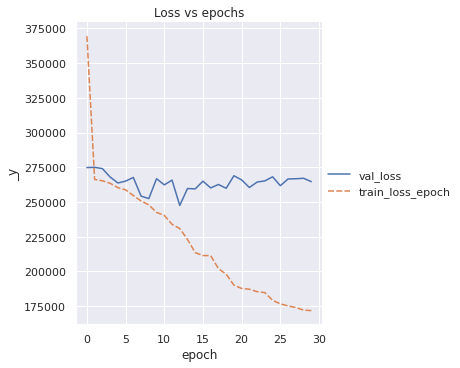

In [13]:
# reading metrics from the logs produced by CSVLogger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

del metrics["step"]
del metrics["train_loss_step"]
# comment if not logging lr changes
# del metrics["lr-Adam"]
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head(10))

sns.relplot(data=metrics, kind="line").set(title='Loss vs epochs')
plt.grid(True);

In [ ]:
# con il LR più alto mostra overfitting
# loss è MAE, quindi l'errore è intorno a 250000/750000, 30%